Check running TensorFlow version

In [1]:
import tensorflow as tf
tf.__version__

'2.0.0-beta1'

# Sentiment movie reviews classification

This is a binary classification problem (2 classes, negative and positive). 

The dataset I will use is [IMDB reviews](https://ai.stanford.edu/~amaas/data/sentiment/), it contains a set of 25,000 highly polar movie reviews for training, and 25,000 for testing.

I will use a basic dense model to start with and find out how well it performs on this dataset. 1D conv, LSTM, GRU, Bidirectional are stuff I can try later.

In [2]:
from tensorflow.keras import datasets
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.sequence import pad_sequences

import matplotlib.pyplot as plt
%matplotlib inline

import random as rand

import numpy as np

## Load IMDB review and get familiar with it

In [3]:
vocab_size = 10000
(train_x, train_y), (test_x, test_y) = datasets.imdb.load_data(num_words=vocab_size)

In [4]:
train_x.shape, train_y.shape

((25000,), (25000,))

In [5]:
test_x.shape, test_y.shape

((25000,), (25000,))

Load the word index dictionary and reverse a few triaing strings

Note: the indices are offset by 3 because 0, 1, and 2 are reserved indices for "padding", "start of sequence", and "unknown".

In [6]:
word_index = datasets.imdb.get_word_index()
word_index_reversed = {v: k for k, v in word_index.items()}

In [7]:
translate_sentence = lambda sentence : " ".join([word_index_reversed.get(word - 3, '?') for word in sentence])

In [8]:
random_indecies = rand.choices(list(range(train_x.shape[0])), k=2)

for index in random_indecies:
    sentence = translate_sentence(train_x[index][1:])
    print(sentence, end="\n\n")

the first cruel intentions the original is my favorite movie of all time it was an absolute masterpiece so how on earth could they make a sequel so downright bad sarah michelle ? was perfect in the first movie in this one amy adams sucks she is terrible and couldn't they have found a chick who actually looked like sarah michelle ? at least the same hair color i mean come on robin ? isn't as bad as adams but he is absolutely terrible when compared to ryan ? the sebastian in the first film is ? ? and much more evil than the sebastian in the prequel and what is up with the story line it basically goes like this br br 1 sebastian has a bad ? at his first school so the movie says although it mentions nothing about him and his dating life and how he has been with girls 2 sebastian moves to new york and just suddenly decides he's going to turn himself around he falls in love with ? might i remind you that in the original sarah michelle ? says quote you broke up with the first person you ever 

## Check how balanced the data is

In [9]:
from collections import Counter

labels_counter = Counter(list(map(int, train_y)))
labels_counter = {k: v for k, v in labels_counter.items()}
labels_counter

{1: 12500, 0: 12500}

## Pad the training and test data

Because of input data is of different sizes, I will set a max length limit on them or pad them if their length was shorter than max length

In [10]:
max_length = 200

# Default :: , padding='pre', truncating='pre'
train_x = pad_sequences(train_x, maxlen=max_length)
test_x = pad_sequences(test_x, maxlen=max_length)

In [11]:
train_x.shape, test_x.shape

((25000, 200), (25000, 200))

## Train

In [12]:
model = Sequential()
model.add(layers.Embedding(vocab_size, 32, input_length=max_length))
model.add(layers.GlobalAveragePooling1D())  # 3% better than using Flatten layer

model.add(layers.Dense(16, activation='relu'))  # More Dense layers with GlobalAveragePooling1D did not improve or worsen the model

# Try l2 and dropout regularizers

# l2 regularizer
# model.add(layers.Dense(16, kernel_regularizer=regularizers.l2(.001), activation='relu'))

# Dropout regularizer
# model.add(layers.Dense(16, activation='relu'))
# model.add(layers.Dropout(0.5))
# model.add(layers.Dense(16, activation='relu'))
# model.add(layers.Dropout(0.5))

model.add(layers.Dense(1, activation='sigmoid'))
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 200, 32)           320000    
_________________________________________________________________
global_average_pooling1d (Gl (None, 32)                0         
_________________________________________________________________
dense (Dense)                (None, 16)                528       
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 17        
Total params: 320,545
Trainable params: 320,545
Non-trainable params: 0
_________________________________________________________________


In [13]:
model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['accuracy'])

In [14]:
history = model.fit(x=train_x, y=train_y, validation_split=0.2, shuffle=True, batch_size=256, epochs=10)
history.history.keys()

W0822 13:36:47.993658 4478498240 deprecation.py:323] From /Users/mostafagazar/anaconda3/envs/py3/lib/python3.6/site-packages/tensorflow/python/ops/math_grad.py:1250: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Train on 20000 samples, validate on 5000 samples
Epoch 1/10
20000/20000 [==============================] - 1s 48us/sample - loss: 0.6749 - accuracy: 0.7087 - val_loss: 0.6461 - val_accuracy: 0.7586
Epoch 2/10
20000/20000 [==============================] - 1s 30us/sample - loss: 0.6068 - accuracy: 0.8005 - val_loss: 0.5630 - val_accuracy: 0.8112
Epoch 3/10
20000/20000 [==============================] - 1s 34us/sample - loss: 0.5118 - accuracy: 0.8403 - val_loss: 0.4720 - val_accuracy: 0.8452
Epoch 4/10
20000/20000 [==============================] - 1s 35us/sample - loss: 0.4177 - accuracy: 0.8665 - val_loss: 0.3976 - val_accuracy: 0.8542
Epoch 5/10
20000/20000 [==============================] - 1s 34us/sample - loss: 0.3454 - accuracy: 0.8812 - val_loss: 0.3501 - val_accuracy: 0.8662
Epoch 6/10
20000/20000 [==============================] - 1s 33us/sample - loss: 0.2952 - accuracy: 0.8929 - val_loss: 0.3195 - val_accuracy: 0.8726
Epoch 7/10
20000/20000 [==============================] -

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

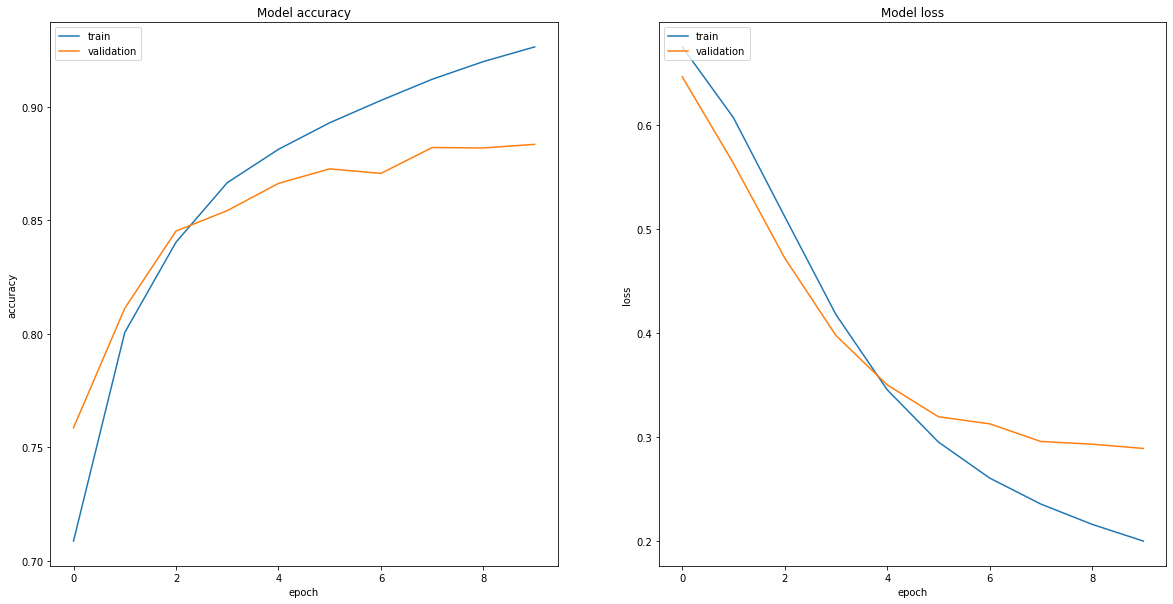

In [15]:
fig = plt.figure(figsize=(20, 10))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')

plt.show()

## Evaluate

In [16]:
loss, accuracy = model.evaluate(x=test_x, y=test_y)
loss, accuracy

25000/25000 [==============================] - 1s 20us/sample - loss: 0.2954 - accuracy: 0.8775


(0.2953742971992493, 0.87752)

## Predict on one sentence

In [17]:
model.trainable = False

# Compile model so changes to trainable would take effect
model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['accuracy'])

In [18]:
sentence

"well overall this movie was pretty much worthless and it's basically a horror movie that ended up being more of a comedy i just rented this movie last night when me and my friends went to blockbuster looking for a scary movie this definitely wasn't what we were looking for but it satisfied us for humor the actors in this movie especially brandon are so fake that it's funny and especially that tracy girl whenever she's in the ? up room telling the clown to go away they show almost no emotion and it's just so obvious that they're acting and also when the clown is looking through that black box paper thing and grabs mark he doesn't even look like he's scared even though the clown like grabbed him and started attacking him and seriously would you just be ? if you were being chased down i'd be ? for my life even though anyone could probably ? that clown because he's like 300 ? not to mention that the effects aren't that great like whenever the clown chops off ? head in the forest then when

In [19]:
index = 0

sentence = test_x[index]
translate_sentence(sentence), test_y[index]

("? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? please give this one a miss br br ? ? and the rest of the cast rendered terrible performances the show is flat flat flat br br i don't know how michael madison could have allowed this one on his plate he almost seemed to know this wasn't going to work out and his performance was quite ? so all you madison fans give this a miss",
 0)

In [20]:
sentence = sentence.reshape(1, *sentence.shape)
sentence.shape

(1, 200)

In [21]:
output = model(sentence)
float(output)

0.15948878228664398